In [1]:
%load_ext autoreload
%autoreload 1
%aimport modules.dataset_auxiliary, modules.classification_auxiliary, modules.ml_auxiliary, modules.bullets, modules.results_auxiliary, modules.bullets

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


import os
import pickle

from modules.bullets import*
from modules.classification_auxiliary import *
from modules.ml_auxiliary import *
from modules.results_auxiliary import *
import copy

from abc import ABC, abstractmethod
import time
import json
import timeit

from tqdm import tqdm

import pystmm


import pathlib
import seaborn as sns


# Form results table

In [10]:
src = 'stages/results_2-ntu/'
form_table, get_fancy_table= form_table_v2, get_fancy_table_v2


src_list = get_target_files(src)
df = form_table(src_list)
table = get_fancy_table(df)
df_f = filter_acc(src, drop_classes=[16])
table = table.merge(df_f[['model', 'acc_drop_fancy', 'acc_merge_fancy']], on='model')



In [11]:
table

,model,"Accuracy, %","Inference time, ms","Fitting time, s",acc_drop_fancy,acc_merge_fancy
0,SVD_max+KNN: {},36.89,140.438,0.01,36.85,36.89
1,"SVD_max+LogReg: {'class_weight': 'balanced', '...",77.49,0.897,26.05,77.55,77.49
2,"SVD_max+RandForest: {'n_estimators': 300, 'max...",50.32(1.93),114.042,28.59,53.42,53.29
3,SVD_max+STMM: {},74.41(0.07),1.129,340.39,74.25,74.31
4,SVD_max+SVMClassifier: {},77.43,8.668,32.14,77.49,77.43
5,SVD_max+XGBoost: {'n_estimators': 300},82.87,32.225,1318.71,82.89,82.93
6,original+KNN: {},61.5,56.203,0.02,61.40,61.50
7,"original+LogReg: {'class_weight': 'balanced', ...",94.73,5.1,1522.68,94.72,94.73
8,"original+RandForest: {'n_estimators': 300, 'ma...",92.95(0.29),77.523,20.52,93.10,93.11
9,original+STMM: {},91.34(0.62),0.776,325.78,90.82,90.78


In [7]:
# file_pkl = src + 'model1-skgest-smpl-center_tucker_full.pkl'
# with open(file_pkl, 'rb') as f:
#     data = pickle.load(f)
            
# preds, y_test = data['preds'], data['y_test']
        

## code


In [5]:

        
        
# def  drop_gesture(preds_in, y_test_in, drop_classes=[16]):
#     preds,  y_test = np.copy(preds_in), np.copy(y_test_in)
    
#     for label in drop_classes:
#         delete_idxs = np.where(y_test == label)
#         y_test = np.delete(y_test, delete_idxs)
#         preds = np.delete(preds, delete_idxs)
        
#     return preds,  y_test

# def  merge_gesture(preds_in, y_test_in, merge_classes=[[17, 16]]):
#     preds,  y_test = np.copy(preds_in), np.copy(y_test_in)
    
#     for label_pair in merge_classes:
#         # update_idxs = np.where(y_test == label_pair[1])
#         update_value =  label_pair[0]
#         y_test[np.where(y_test == label_pair[1])] = update_value
#         preds[np.where(preds == label_pair[1])] = update_value
        
#     return preds,  y_test




# def filter_acc(src, drop_classes=[16], merge_classes=[[17, 16]]):
#     df = pd.DataFrame()

#     # src_list_pkl = get_target_files(src, suffix='.pkl')
#     src_list_json = get_target_files(src, suffix='.json')
    
#     for file_json in src_list_json:
        
#         file_pkl = file_json[:-5] + '.pkl'
        
#         main_dict = {}
#         file_name = pathlib.Path(file_json).stem
#         pref = '_'.join(file_name.split('_')[1:])
#         if pref == '':
#             pref = 'original'
#         # pref = [pref] if pref != '' else []

#         res_dict = load_json(file_json)
#         main_dict['model'] = '+'.join([pref] + [res_dict['model']])
        
#         with open(file_pkl, 'rb') as f:
#             data = pickle.load(f)

#         preds, y_test = data['preds'], data['y_test']
        
#         preds_drop, y_test_drop = drop_gesture(preds, y_test, drop_classes)
#         acc_drop = accuracy_score(y_test_drop, preds_drop)
#         main_dict['acc_drop'] = [acc_drop]
#         main_dict['acc_drop_fancy'] = np.round(100*acc_drop, 2)
        
#         preds_merge, y_test_merge = merge_gesture(preds, y_test, merge_classes)
#         acc_merge = accuracy_score(y_test_merge, preds_merge)
#         main_dict['acc_merge'] = [acc_merge]
#         main_dict['acc_merge_fancy'] = np.round(100*acc_merge, 2)
        
        
        
#         df_row = pd.DataFrame(main_dict)
#         df = pd.concat([df, df_row])
        
        
#     df = df.sort_values(['model'])
#     df = df.reset_index(drop=True)
#     return df
 
        
     

In [67]:
# def form_table_v1(src_list, dst=None):
    
#     df = pd.DataFrame()
#     for src_file in src_list:
#         res_dict = load_json(src_file)
#         main_dict = {}
        
        
        
#         for key in ['model','mean_acc', 'std_acc', 'inf_time']:
#             main_dict[key] = [res_dict[key]]
           
#         file_name = pathlib.Path(src_file).stem
#         pref = '_'.join(file_name.split('_')[1:])
#         if pref == '':
#             pref = 'original'
#         # pref = [pref] if pref != '' else []
        
#         main_dict['model'] = '+'.join([pref] + [res_dict['model']])
#         df_row = pd.DataFrame(main_dict)
#         df = pd.concat([df, df_row])
        
#     df = df.sort_values(['model'])
    
#     df = df.reset_index(drop=True)
#     return df


# def get_fancy_table(table):
#     mean_col = (100*table['mean_acc']).round(2).map(lambda x: str(x))
#     std_col = (100*table['std_acc']).round(2).map(lambda x: f"({x})" if str(x) != 'nan' else '')
#     table['Accuracy, %'] = mean_col + std_col
#     table['Inference time, ms'] = (table['inf_time']*1000).round(3).map(lambda x: str(x) + '')
#     return table[['model', 'Accuracy, %', 'Inference time, ms']]
    
    

In [ ]:
# def get_target_files(src, suffix='.json'):
#     src = pathlib.Path(src)
#     src_list = []
#     if src.is_file():
#         src_list += [str(src)]
    
#     if src.is_dir():
#         for src_file in os.listdir(src):
#             if pathlib.Path(src_file).suffix == suffix:
#                 src_list += [str(src_file)]
#     return src_list





In [2]:
ls

backup/   gestures.txt         requirements.txt   tensors.ipynb
bullets/  model_results.ipynb  script_work.ipynb  tensors_my.ipynb
env/      modules/             stages/


# CV results

/home/s.gostilovich/gesture_progect/gesture_classification/env/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 57.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


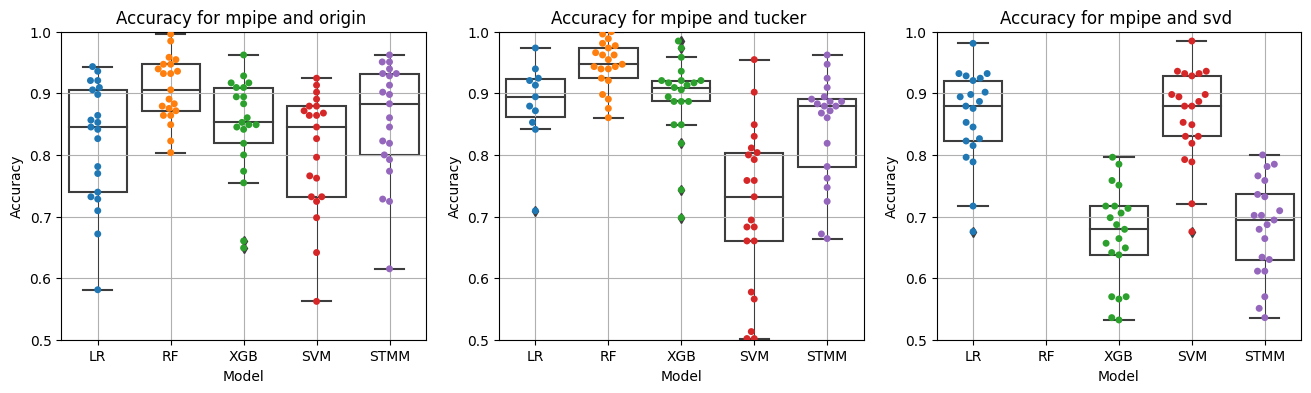

In [10]:
# dir = 
t_src = 'stages/results_cv/model{n_model}-skgest-{skelet}-center-folds{transform}.json'
# res = load_json(src)
skelets = ['mpipe', 'ntu', 'smpl']
transform_pairs = [['origin', ''], ['tucker', '_tucker_full'], 
                   ['svd', '_SVD_max']]


skelet = 'mpipe'
transform_pair = ['origin', '']

# name_dict = {'LogReg': 'LR', 'RandForest': 'RF', 'XGBoost': 'XGB', 'SVMClassifier':'SVM', 'STMM':'STMM'}
name_dict = {'LogReg': 'LR', 'RandForest': 'RF', 'XGBoost': 'XGB', 'SVMClassifier':'SVM'}


figure, axes = plt.subplots(1, 3, figsize=(16, 4))
table_dict = {}
for i, transform_pair in enumerate(transform_pairs):
    ax = axes[i]
    acc_dicts, model_names = [], []
    try:
        for n_model in [1, 2, 3, 4, 5]:
            
                src = t_src.format(n_model=n_model, skelet=skelet, transform=transform_pair[1])
                if os.path.exists(src):
                    acc_dict, model_name = collect_accuracy(src)
                    acc_dicts += [acc_dict]
                    model_names += [model_name]
                
        table = form_common_table(acc_dicts, model_names, name_dict=name_dict)
        table_dict[f"{skelet}-{transform_pair[0]}"] = table
        
        plot_swarmboxplot(table, ax=ax,)
        ax.set_ylim([0.5, 1])
        ax.set_title(f"Accuracy for {skelet} and {transform_pair[0]} ")
        ax.grid()
        # plt.show()
                         
    except:
        print(f"Accuracy for {skelet} and {transform_pair[0]} was skipped")
        
        
        
    



In [11]:
# model = 'RF'
for transform in ['origin', 'tucker', 'svd']:  
    for model in ['LR', 'RF', 'XGB', 'SVM', 'STMM']:
    
        key = f"{skelet}-{transform}"
        table_ = table_dict[key]
        mean_acc = table_[table_['Model'] == model]['Accuracy'].mean()
        std_acc = table_[table_['Model'] == model]['Accuracy'].std(ddof=1)
        print(key, model,  f"{100*mean_acc:.2f}({100*std_acc:.2f})", sep='\t')

mpipe-origin	LR	82.07(9.84)
mpipe-origin	RF	90.66(5.20)
mpipe-origin	XGB	84.62(8.20)
mpipe-origin	SVM	80.68(9.71)
mpipe-origin	STMM	85.59(9.20)
mpipe-tucker	LR	88.37(6.96)
mpipe-tucker	RF	94.50(3.88)
mpipe-tucker	XGB	89.00(6.89)
mpipe-tucker	SVM	71.59(13.02)
mpipe-tucker	STMM	84.35(8.55)
mpipe-svd	LR	86.16(7.47)
mpipe-svd	RF	3.16(0.55)
mpipe-svd	XGB	66.81(7.83)
mpipe-svd	SVM	86.40(7.55)
mpipe-svd	STMM	68.28(7.77)


<AxesSubplot:xlabel='model', ylabel='acc'>

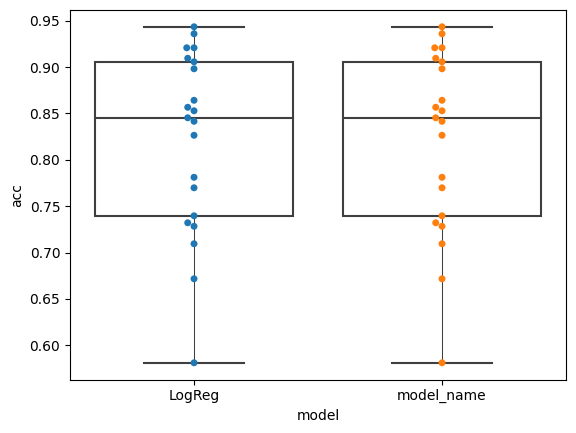

In [119]:

sns.swarmplot( x='model', y='acc', data=df)
sns.boxplot(x='model', y='acc', data=df, showcaps=True, boxprops={'facecolor':'None'},
                 showfliers=True,whiskerprops={'linewidth':0.75})




# code

In [132]:


# def collect_accuracy(src, value_key='mean_acc', name_key = 'model'):
#     res_list = load_json(src)
#     model_name = res_list[0][name_key].split(":")[0]
#     acc_dict = {}
#     for res in res_list:
#         name = res[name_key].split("-")[-1]
#         acc_dict[name] = [res[value_key]]
#     acc_dict = dict(sorted(acc_dict.items()))
#     return acc_dict, model_name


# def form_common_table(acc_dicts, model_names, table=None):
#     acc_col, model_col = 'Accuracy', 'Model'
#     if table is None:
#         table = pd.DataFrame()
        
#     for acc_dict, model_name in zip(acc_dicts, model_names):
#         df = pd.DataFrame(acc_dict, index=[acc_col]).T
#         df[model_col] = model_name
#         table = pd.concat([table, df])
#     return table

# def plot_swarmboxplot(table, y='Accuracy', x='Model'):
#     sns.swarmplot( x=x, y=y, data=table)
#     sns.boxplot(x=x, y=y, data=table, showcaps=True, boxprops={'facecolor':'None'},
#                     showfliers=True,whiskerprops={'linewidth':0.75})
#     ax = plt.gca()
#     ax.set_ylim([0.5, 1])
    
        
        
    